## SSZ-QL and GMP
This is a PoC pursues three technical objectives:
- reinforce the rationale for the Fellowship project
- quantify the efficiency improvements unlocked by the proposed approach
- validate merkle proofs and multiproofs in a realistic setting

Our starting point is `class BeaconState`, the "God's object" that gives us a versatile surface for exercising multiple use-case scenarios.

In [1]:
# Added this snippet to prevent uploading a beacon state to github: 
# Download the finalized BeaconState as raw SSZ
# (≈︎ `curl -o state.ssz -H 'Accept: application/octet-stream' \
#    https://beaconstate.ethstaker.cc/eth/v2/debug/beacon/states/finalized`)

import requests

RPC = "https://beaconstate.ethstaker.cc"
ENDPOINT = "/eth/v2/debug/beacon/states/finalized"
HEADERS = {"Accept": "application/octet-stream"}
OUTFILE = "state.ssz"

with requests.get(RPC+ENDPOINT, headers=HEADERS, stream=True, timeout=30) as resp:
    resp.raise_for_status()                     
    with open(OUTFILE, "wb") as fp:
        for chunk in resp.iter_content(8192):   
            if chunk:                           
                fp.write(chunk)

In [2]:
# Here we are using the same "BeaconState" from a given SSZ file for the sake of simplicity. We could retrieve different ones on-demmand, but it would slow down the process.
# As there are many "leaves" in the tree, another smaller class (BeaconBlock) is provided at the end to better visualize the merkle tree structure.
import os
import eth2spec.electra.mainnet as spec

beacon_state_path = "state.ssz"
beacon_state_size = os.stat(beacon_state_path).st_size
megabyte = 1024 * 1024
print(f"Beacon state file size: {beacon_state_size} bytes - {beacon_state_size / megabyte:.2f} MB")

state: spec.BeaconState
with open(beacon_state_path, "rb") as f:
    state = spec.BeaconState.deserialize(f, beacon_state_size)


print(f"Successfully loaded the beacon state for slot {state.slot}")


Beacon state file size: 284646798 bytes - 271.46 MB
Successfully loaded the beacon state for slot 12145344


In [3]:
current_validators = len(state.validators)
validator_size = len(spec.Validator().encode_bytes())
total_validators_size = current_validators * validator_size
print(f"validators field {current_validators} - each validator size is {validator_size} bytes - Validators field size {total_validators_size / megabyte:.2f} MB")

balances_size = 8 # uint64 
total_balances_size = current_validators * balances_size
print(f"balances field {current_validators} - each balance size is {balances_size} bytes - Balances field size {total_balances_size / megabyte:.2f} MB")

print(f"Out ot the {beacon_state_size / megabyte:.2f} MB beacon state:\n\t- the validators field is {total_validators_size / megabyte:.2f} MB\n\t- the balances field is {total_balances_size / megabyte:.2f} MB\n\t- the rest is {(beacon_state_size - total_validators_size - total_balances_size) / megabyte:.2f} MB")

# Maybe draw a pie chart

validators field 2011717 - each validator size is 121 bytes - Validators field size 232.14 MB
balances field 2011717 - each balance size is 8 bytes - Balances field size 15.35 MB
Out ot the 271.46 MB beacon state:
	- the validators field is 232.14 MB
	- the balances field is 15.35 MB
	- the rest is 23.97 MB


([<matplotlib.patches.Wedge at 0x3b72db7d0>,
 [Text(-0.9880693451650904, 0.4834448977339917, 'validators'),
  Text(0.8178919423052086, -0.7355628937842185, 'balances'),
  Text(1.0579438107176957, -0.30125552835445263, 'other fields')],
 [Text(-0.5389469155445947, 0.2636972169458136, '85.5%'),
  Text(0.4461228776210228, -0.40121612388230093, '5.7%'),
  Text(0.5770602603914704, -0.16432119728424685, '8.8%')])

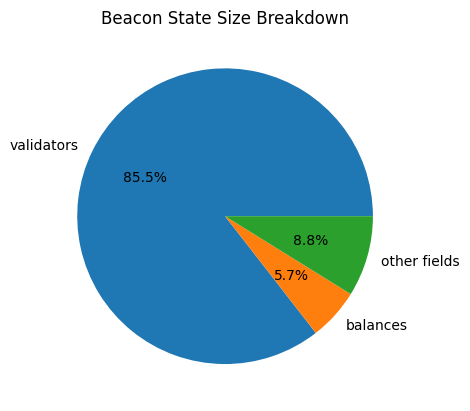

In [4]:
import matplotlib.pyplot as plt 

# https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html

labels = 'validators', 'balances', 'other fields'
sizes = [(total_validators_size / megabyte), (total_balances_size / megabyte), ((beacon_state_size - total_validators_size - total_balances_size) / megabyte)]

fig, ax = plt.subplots()
ax.set_title('Beacon State Size Breakdown')
ax.pie(sizes, labels=labels,  autopct='%1.1f%%')

# We could iterate over the fields of the BeaconState and make a pie chart with the sizes of each field
# field_names = list(spec.BeaconState.__annotations__)
# print(field_names)
# state.__getattr__(field_names[0])

SSZ-QL MUST provide enough flexibility to ask for any arbitrary field or data from any object within the Consensus Layer.

Below are several demonstration queries that highlight its capabilities:

In [5]:
import json

# Case 1: verify domain with the genesis_validators_root and the current fork version
# `POST` https://RPC/eth/v1/beacon/states/finalized/query
# {
#   "query": [
#     {
#       "path": ".genesis_validators_root",
#       "include_proof": false
#     },
#     {
#       "path": ".fork.current_version",
#       "include_proof": false
#     }
#   ]
# }

# This toy example helps us identify the structure of the SSZ-QL response, there could be multiple ways to represent the data: 
# - inferring to which path the values correspond to by their order
# - explicitly adding the `path` field to each data retrieved.

sszql_response = json.dumps(
    {
        "version": "electra",
        "execution_optimistic": True,
        "finalized": True,
        "data": [
            {
                "value": "0x"+state.genesis_validators_root.hex(), 
            },
            {
                "value": "0x"+state.fork.current_version.hex(),
            }
        ]
    },
    indent=2
)

print("SSZ-QL response (sorted data reply): \n",sszql_response)

sszql_response = json.dumps(
    {
        "version": "electra",
        "execution_optimistic": True,
        "finalized": True,
        "data": [
            {
                "path": ".fork.current_version",
                "value": "0x"+state.fork.current_version.hex(),
            },
            {
                "path": ".genesis_validators_root",
                "value": "0x"+state.genesis_validators_root.hex(), 
            }
        ]
    },
    indent=2
)

print("SSZ-QL response (explicit): \n",sszql_response)

# I like it better when the data is explicit and self-contained, so the query is not needed to understand the response.

SSZ-QL response (sorted data reply): 
 {
  "version": "electra",
  "execution_optimistic": true,
  "finalized": true,
  "data": [
    {
      "value": "0x4b363db94e286120d76eb905340fdd4e54bfe9f06bf33ff6cf5ad27f511bfe95"
    },
    {
      "value": "0x05000000"
    }
  ]
}
SSZ-QL response (explicit): 
 {
  "version": "electra",
  "execution_optimistic": true,
  "finalized": true,
  "data": [
    {
      "path": ".fork.current_version",
      "value": "0x05000000"
    },
    {
      "path": ".genesis_validators_root",
      "value": "0x4b363db94e286120d76eb905340fdd4e54bfe9f06bf33ff6cf5ad27f511bfe95"
    }
  ]
}


The previous SSZ-QL query shows only a minimal use case and offers little practical value because the returned fields are not cryptographically proven.

The core objective of SSZ-QL & GMP is to fetch any subset of fields efficiently. Bundling Merkle proofs with each response lets a client verify the data’s integrity without downloading the entire beacon state.

In [ ]:
# Example of how to compute merkle proofs of the genesis_validators_root using eth2spec 

from eth2spec.electra.mainnet import get_generalized_index, compute_merkle_proof, is_valid_merkle_branch,floorlog2, BeaconState, Bytes32

proofs = compute_merkle_proof(state, get_generalized_index(BeaconState,'genesis_validators_root'))
state_root = state.hash_tree_root()

assert is_valid_merkle_branch(
      leaf = state.genesis_validators_root,
      branch = proofs,
      depth = floorlog2(get_generalized_index(BeaconState,'genesis_validators_root')),
      index = get_generalized_index(BeaconState,'genesis_validators_root'),
      root = state_root,
)

# The question is: should we make an explicit answer with all these fields or just return the leaf, hashes and root?
# leafs are needed for sure - the specific field 
# branch - the hashes of the nodes in the merkle tree
# depth - of the field in the merkle tree
# index - the index of the field in the merkle tree
# root - the root of the merkle tree

# def is_valid_merkle_branch(
#     leaf: Bytes32, branch: Sequence[Bytes32], depth: uint64, index: uint64, root: Root
# ) -> bool:
#     """
#     Check if ``leaf`` at ``index`` verifies against the Merkle ``root`` and ``branch``.
#     """
#     value = leaf
#     for i in range(depth):
#         if index // (2**i) % 2:
#             value = hash(branch[i] + value)
#         else:
#             value = hash(value + branch[i])
#     return value == root


In [ ]:
from remerkleable.core import Path

# Helper function to prevent constantly adding the "0x" prefix to the hex representation of bytes
def to_hex(b: Bytes32 | bytes) -> str:
    """Return 0x-prefixed hex string."""
    return "0x" + b.hex()

In [18]:
# Case 2: verify domain with the genesis_validators_root and the current fork version
# `POST` https://RPC/eth/v1/beacon/states/finalized/query
# {
#   "query": [
#     {
#       "path": ".genesis_validators_root",
#       "include_proof": true
#     },
#     {
#       "path": ".fork.current_version",
#       "include_proof": true
#     }
#   ]
# }
# This toy example helps us identify the structure of the SSZ-QL response, both fields are to be proven. Do they want single merkle proofs or just a multi proof?
# We need to improve the query

genesis_validators_root_path = Path(spec.BeaconState) / 'genesis_validators_root'
genesis_validators_root_gindex = genesis_validators_root_path.gindex()

fork_version_path = Path(spec.BeaconState) / 'fork' / 'current_version'
fork_version_gindex = fork_version_path.gindex()

print(f"Merkle path for genesis_validators_root: {genesis_validators_root_path.path}")
print(f"\nTarget gindex: {genesis_validators_root_gindex}")

print(f"Merkle path for genesis_validators_root: {fork_version_path.path}")
print(f"Target gindex: {fork_version_gindex}")

print(f"Fork current version: {state.fork.current_version.hex()}")

state_root = state.hash_tree_root()
print(f"Beacon state hash tree root: {to_hex(state_root)}")

genesis_validators_root_witness=compute_merkle_proof(state, genesis_validators_root_gindex)
fork_version_witness=compute_merkle_proof(state, fork_version_gindex)


sszql_response = json.dumps(
    {
        "version": "electra",
        "execution_optimistic": True,
        "finalized": True,
        "data": [
            {
                "path": ".genesis_validators_root",
                "value": to_hex(state.genesis_validators_root),
                "proofs": [
                    {
                        "gindex": int(genesis_validators_root_gindex),
                        "witness": [to_hex(sib) for sib in genesis_validators_root_witness],
                    }
                ],
                "state_root": to_hex(state_root),
            },
            {
                "path": ".fork.current_version",
                "value": to_hex(state.fork.current_version),
                "proofs": [
                    {
                        "gindex": int(fork_version_gindex),
                        "witness": [to_hex(sib) for sib in fork_version_witness],
                    }
                ],
                "state_root": to_hex(state_root),  # (puede omitirse si es común)
            },
        ],
    },
    indent=2,
)

print("\nSSZ-QL response:\n", sszql_response)

Merkle path for genesis_validators_root: [('genesis_validators_root', <class 'eth2spec.electra.mainnet.Root'>)]

Target gindex: 65
Merkle path for genesis_validators_root: [('fork', <class 'eth2spec.electra.mainnet.Fork'>), ('current_version', <class 'eth2spec.electra.mainnet.Version'>)]
Target gindex: 269
Fork current version: 05000000
Beacon state hash tree root: 0xfa1b8661fb64caf152156efb0094e001ce24e5a54bbf526c617d14a6062611c4

SSZ-QL response:
 {
  "version": "electra",
  "execution_optimistic": true,
  "finalized": true,
  "data": [
    {
      "path": ".genesis_validators_root",
      "value": "0x4b363db94e286120d76eb905340fdd4e54bfe9f06bf33ff6cf5ad27f511bfe95",
      "proofs": [
        {
          "gindex": 65,
          "witness": [
            "0x5730c65f00000000000000000000000000000000000000000000000000000000",
            "0xc3ec868a79c18578a47b5fd040fc95f2e10f44aec73a4d219d32030cd932d236",
            "0x55357a61a584dece58465a4e250565aa7735aff7720a20a1385615b127529810",
 

As expected, most single-leaf proofs share identical hash nodes because the leaves lie on overlapping Merkle paths. A compact Merkle multiproof eliminates this redundancy by proving all target leaves in one shot, shipping only the minimal witness set.

### Multiproofs
The multiproof generation is based on [Consensus Layer spec](https://github.com/ethereum/consensus-specs/blob/dev/ssz/merkle-proofs.md).
We need to only model the input and output.

In [19]:
from eth2spec.electra.mainnet import GeneralizedIndex, Sequence, Set, Bytes32, Root
from eth2spec.utils.hash_function import hash

def get_power_of_two_ceil(x: int) -> int:
    if x <= 1:
        return 1
    elif x == 2:
        return 2
    else:
        return 2 * get_power_of_two_ceil((x + 1) // 2)


def get_power_of_two_floor(x: int) -> int:
    if x <= 1:
        return 1
    if x == 2:
        return x
    else:
        return 2 * get_power_of_two_floor(x // 2)
    
def concat_generalized_indices(*indices: GeneralizedIndex) -> GeneralizedIndex:
    """
    Given generalized indices i1 for A -> B, i2 for B -> C .... i_n for Y -> Z, returns
    the generalized index for A -> Z.
    """
    o = GeneralizedIndex(1)
    for i in indices:
        o = GeneralizedIndex(o * get_power_of_two_floor(i) + (i - get_power_of_two_floor(i)))
    return o

def get_generalized_index_length(index: GeneralizedIndex) -> int:
    """
    Return the length of a path represented by a generalized index.
    """
    return int(log2(index))

def get_generalized_index_bit(index: GeneralizedIndex, position: int) -> bool:
    """
    Return the given bit of a generalized index.
    """
    return (index & (1 << position)) > 0

def generalized_index_sibling(index: GeneralizedIndex) -> GeneralizedIndex:
    return GeneralizedIndex(index ^ 1)

def generalized_index_child(index: GeneralizedIndex, right_side: bool) -> GeneralizedIndex:
    return GeneralizedIndex(index * 2 + right_side)

def generalized_index_parent(index: GeneralizedIndex) -> GeneralizedIndex:
    return GeneralizedIndex(index // 2)

def get_branch_indices(tree_index: GeneralizedIndex) -> Sequence[GeneralizedIndex]:
    """
    Get the generalized indices of the sister chunks along the path from the chunk with the
    given tree index to the root.
    """
    o = [generalized_index_sibling(tree_index)]
    while o[-1] > 1:
        o.append(generalized_index_sibling(generalized_index_parent(o[-1])))
    return o[:-1]

def get_path_indices(tree_index: GeneralizedIndex) -> Sequence[GeneralizedIndex]:
    """
    Get the generalized indices of the chunks along the path from the chunk with the
    given tree index to the root.
    """
    o = [tree_index]
    while o[-1] > 1:
        o.append(generalized_index_parent(o[-1]))
    return o[:-1]

def get_helper_indices(indices: Sequence[GeneralizedIndex]) -> Sequence[GeneralizedIndex]:
    """
    Get the generalized indices of all "extra" chunks in the tree needed to prove the chunks with the given
    generalized indices. Note that the decreasing order is chosen deliberately to ensure equivalence to the
    order of hashes in a regular single-item Merkle proof in the single-item case.
    """
    all_helper_indices: Set[GeneralizedIndex] = set()
    all_path_indices: Set[GeneralizedIndex] = set()
    for index in indices:
        all_helper_indices = all_helper_indices.union(set(get_branch_indices(index)))
        all_path_indices = all_path_indices.union(set(get_path_indices(index)))

    return sorted(all_helper_indices.difference(all_path_indices), reverse=True)

def calculate_merkle_root(leaf: Bytes32, proof: Sequence[Bytes32], index: GeneralizedIndex) -> Root:
    assert len(proof) == get_generalized_index_length(index)
    for i, h in enumerate(proof):
        if get_generalized_index_bit(index, i):
            leaf = hash(h + leaf)
        else:
            leaf = hash(leaf + h)
    return leaf


def verify_merkle_proof(
    leaf: Bytes32, proof: Sequence[Bytes32], index: GeneralizedIndex, root: Root
) -> bool:
    return calculate_merkle_root(leaf, proof, index) == root


def calculate_multi_merkle_root(
    leaves: Sequence[Bytes32], proof: Sequence[Bytes32], indices: Sequence[GeneralizedIndex]
) -> Root:
    assert len(leaves) == len(indices)
    helper_indices = get_helper_indices(indices)
    # print("Helper indices:", helper_indices)
    assert len(proof) == len(helper_indices)
    objects = {
        **{index: node for index, node in zip(indices, leaves)},
        **{index: node for index, node in zip(helper_indices, proof)},
    }
    # print("Initial objects:", objects  )
    keys = sorted(objects.keys(), reverse=True)
    pos = 0
    while pos < len(keys):
        k = keys[pos]
        if k in objects and k ^ 1 in objects and k // 2 not in objects:
            objects[GeneralizedIndex(k // 2)] = hash(
                objects[GeneralizedIndex((k | 1) ^ 1)] + objects[GeneralizedIndex(k | 1)]
            )
            keys.append(GeneralizedIndex(k // 2))
        pos += 1
    return objects[GeneralizedIndex(1)]

leaves = [
    state.genesis_validators_root,                      # already Bytes32
    state.fork.current_version.hash_tree_root(),        # needs to convert from Version to Bytes32
]

gvr_branch = compute_merkle_proof(state, genesis_validators_root_gindex) 
fv_branch  = compute_merkle_proof(state, fork_version_gindex)            


indices = [
    GeneralizedIndex(genesis_validators_root_gindex),
    GeneralizedIndex(fork_version_gindex),
]
helper_indices = get_helper_indices(indices)

# Build an {gindex: node} map with everything we have
objects: dict[GeneralizedIndex, Bytes32] = {
    indices[0]: leaves[0],
    indices[1]: leaves[1],
    **dict(zip(get_branch_indices(indices[0]), gvr_branch)),
    **dict(zip(get_branch_indices(indices[1]), fv_branch)),
}


# Proof list must follow helper-index order returned by get_helper_indices
proof = [objects[i] for i in helper_indices]


# --- final multi-proof verification --------------------------------------
root = calculate_multi_merkle_root(leaves, proof, indices)


assert root == state.hash_tree_root()
print("Multi-proof OK; reconstructed root =", root.hex())

Multi-proof OK; reconstructed root = fa1b8661fb64caf152156efb0094e001ce24e5a54bbf526c617d14a6062611c4


In [20]:
# Case 3: verify domain with the genesis_validators_root and the current forkk version. Using Merkle Multiproof
# `POST` https://RPC/eth/v1/beacon/states/finalized/query
# {
#   "query": [
#     {
#       "path": ".genesis_validators_root",
#       "include_proof": true
#     },
#     {
#       "path": ".fork.current_version",
#       "include_proof": true
#     }
#   ], 
#   "proof_type": "merkle_multiproof" # --- this is the new field we are adding to the query ---
# }

# Compute Merkle Multiproof for the genesis_validators_root and current fork version
leaves = [
    state.genesis_validators_root,                      # already Bytes32
    state.fork.current_version.hash_tree_root(),        # needs to convert from Version to Bytes32
]

# print("Leaves:", [x.hex() for x in leaves])

gvr_branch = compute_merkle_proof(state, genesis_validators_root_gindex) 
fv_branch  = compute_merkle_proof(state, fork_version_gindex)     

# print("GVR branch:", [x.hex() for x in gvr_branch])
# print("FV branch:", [x.hex() for x in fv_branch])

indices = [
    GeneralizedIndex(genesis_validators_root_gindex),
    GeneralizedIndex(fork_version_gindex),
]

# print("Indices:", [i for i in indices])

helper_indices = get_helper_indices(indices)

# print("Helper indices:", helper_indices)

# Build an {gindex: node} map with everything we have
objects: dict[GeneralizedIndex, Bytes32] = {
    indices[0]: leaves[0],
    indices[1]: leaves[1],
    **dict(zip(get_branch_indices(indices[0]), gvr_branch)),
    **dict(zip(get_branch_indices(indices[1]), fv_branch)),
}


# Proof list must follow helper-index order returned by get_helper_indices
proof = [objects[i] for i in helper_indices]

# print("**********proof:", proof)

# --- final multi-proof verification --------------------------------------
root = calculate_multi_merkle_root(
    leaves=leaves,
    proof=proof,
    indices=indices,
)

assert root == state.hash_tree_root()
# print("Multi-proof OK; reconstructed root =", root.hex())

sszql_response = json.dumps(
    {
        "version": "electra",
        "execution_optimistic": True,
        "finalized": True,
        "data": [
            {
                "proofs": [
                    {
                        # "leaves": ['0x'+x.hex() for x in leaves], 
                        "hashes": [[int(idx), "0x" + node.hex()] for idx, node in objects.items()],
                    }
                ],
                "state_root": "0x"+state_root.hex()
            }
        ]
    },
    indent=2
)


print("\n\nSSZ-QL response: \n",sszql_response)



SSZ-QL response: 
 {
  "version": "electra",
  "execution_optimistic": true,
  "finalized": true,
  "data": [
    {
      "proofs": [
        {
          "hashes": [
            [
              65,
              "0x4b363db94e286120d76eb905340fdd4e54bfe9f06bf33ff6cf5ad27f511bfe95"
            ],
            [
              269,
              "0x0500000000000000000000000000000000000000000000000000000000000000"
            ],
            [
              64,
              "0x5730c65f00000000000000000000000000000000000000000000000000000000"
            ],
            [
              33,
              "0xc3ec868a79c18578a47b5fd040fc95f2e10f44aec73a4d219d32030cd932d236"
            ],
            [
              17,
              "0x55357a61a584dece58465a4e250565aa7735aff7720a20a1385615b127529810"
            ],
            [
              9,
              "0xede212bf871edd6bd729864c4c65a564255c9aec77c2c54df5d173575c39d1d2"
            ],
            [
              5,
              "0xd80d

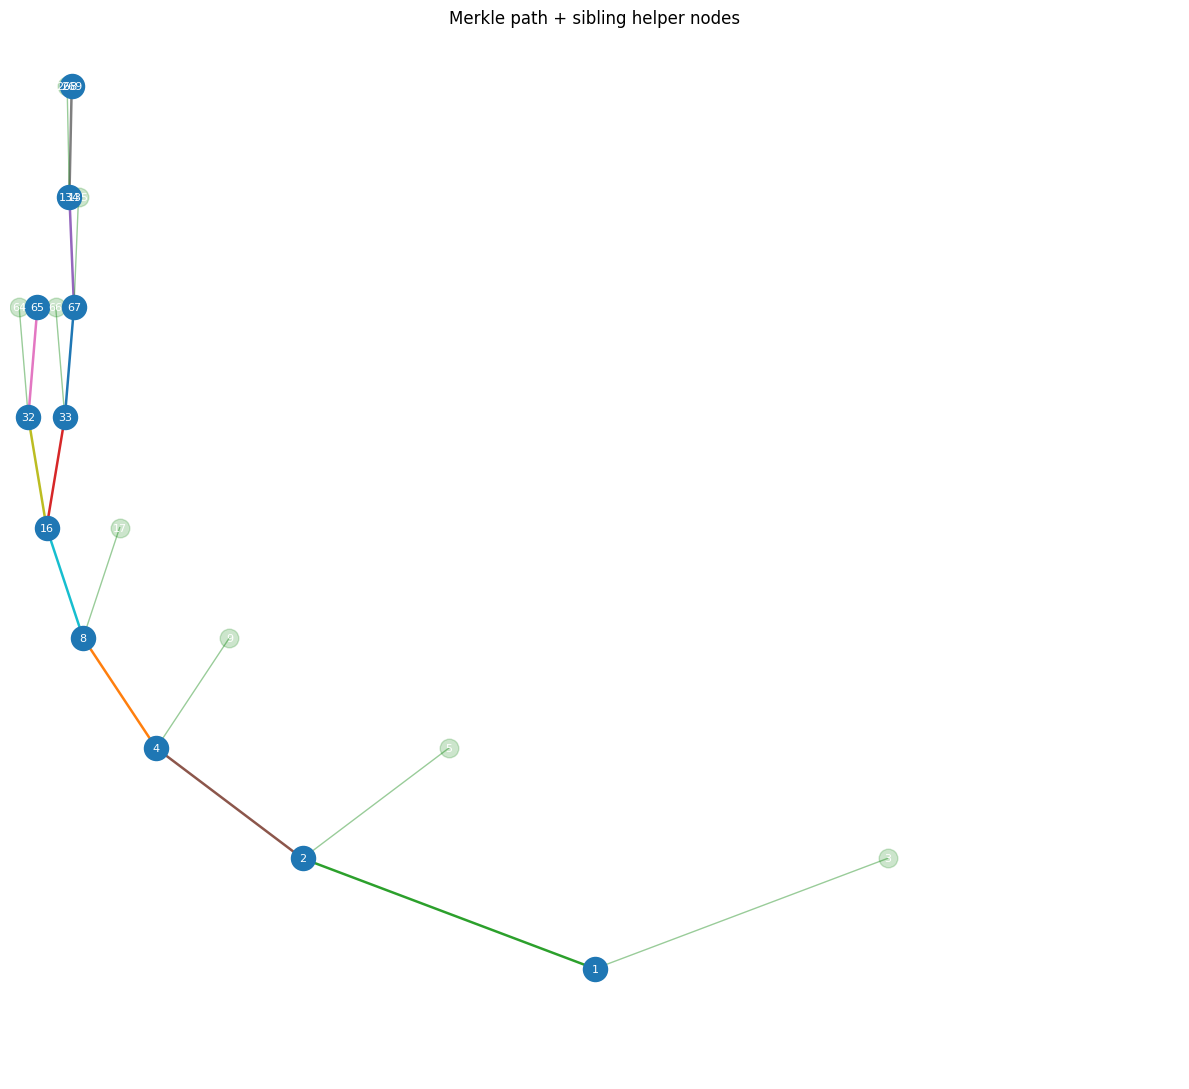

In [21]:
import matplotlib.pyplot as plt

def plot_merkle_paths(gindexes):
    """
    Draw only the nodes required to verify the given leaves:
      • every node on each leaf-to-root path (inclusive), and
      • the sibling (“helper”) nodes needed for proof verification.

    Path nodes are drawn in the foreground; helper-only nodes/edges appear
    semi-transparent.

    Parameters
    ----------
    gindexes : Sequence[int]
        Generalised indices of the leaves to prove.
    """
    if not gindexes:
        raise ValueError("gindexes must contain at least one index")

    # ── helpers ─────────────────────────────────────────────────────────────
    def depth(idx: int) -> int:               # root depth == 0
        return idx.bit_length() - 1

    max_depth = max(depth(g) for g in gindexes)

    # ── path nodes (leaf→root) ──────────────────────────────────────────────
    path_nodes = set()
    for g in gindexes:
        cur = g
        while True:
            path_nodes.add(cur)
            if cur == 1:
                break
            cur //= 2

    # ── helper (sibling) nodes ──────────────────────────────────────────────
    helper_indices = get_helper_indices([GeneralizedIndex(g) for g in gindexes])
    helper_nodes = set(int(h) for h in helper_indices)

    nodes_to_plot = path_nodes | helper_nodes
    edges_to_plot = {
        (n, n // 2) for n in nodes_to_plot
        if n != 1 and (n // 2) in nodes_to_plot
    }

    # ── 2-D layout ──────────────────────────────────────────────────────────
    coords = {}
    for n in nodes_to_plot:
        d = depth(n)
        slot_w = 2 ** (max_depth - d)
        x = (n & ((1 << d) - 1)) * slot_w + slot_w / 2
        y = max_depth - d
        coords[n] = (x, y)

    # ── plot ────────────────────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(12, 1.1 * (max_depth + 2)))

    # edges: helpers (gray) then path
    for child, parent in edges_to_plot:
        x1, y1 = coords[child]
        x2, y2 = coords[parent]
        if child in path_nodes and parent in path_nodes:
            ax.plot([x1, x2], [y1, y2], linewidth=1.8)
        else:
            ax.plot([x1, x2], [y1, y2], color="green", alpha=0.4, linewidth=1)

    # nodes: helpers then path
    helper_only = [n for n in helper_nodes if n not in path_nodes]
    if helper_only:
        xs, ys = zip(*(coords[n] for n in helper_only))
        ax.scatter(xs, ys, s=180, color="green", alpha=0.2, zorder=2)

    xs, ys = zip(*(coords[n] for n in path_nodes))
    ax.scatter(xs, ys, s=300, zorder=3)

    # labels
    for n, (x, y) in coords.items():
        ax.text(x, y, str(n), ha="center", va="center", fontsize=8, zorder=4, color="white")

    # axes cosmetics
    ax.set_ylim(-0.5, max_depth + 1)
    ax.set_xlim(0, 2 ** max_depth)
    ax.set_yticks(range(max_depth + 1))
    ax.set_yticklabels([f"depth {max_depth - d}" for d in range(max_depth + 1)])
    ax.invert_yaxis()
    ax.axis("off")
    ax.set_title("Merkle path + sibling helper nodes")
    plt.tight_layout()
    plt.show()

plot_merkle_paths([genesis_validators_root_gindex, fork_version_gindex])

# Next steps
[Pureth (EIP-7919)](https://eips.ethereum.org/EIPS/eip-7919) proposes the usage of SSZ in CL and also in EL.
When this EIP comes to life, the importance of SSZ-QL will grow. A new specification should be done to extend the current one with the generation a merkle proofs from the EL side.

TODO
- [] watch out merkle tree generation
- [] watch out merkle tree proofs input/output data 
- [] Showcase diagram with sparse merkle tree
- [] Check Etan's comment

In [22]:
RPC      = "https://beaconstate.ethstaker.cc"
URL      = f"{RPC}/eth/v2/beacon/blocks/finalized"
HEADERS  = {"Accept": "application/octet-stream"}
OUTFILE  = "block.ssz"

with requests.get(URL, headers=HEADERS, stream=True, timeout=30) as resp:
    resp.raise_for_status()
    with open(OUTFILE, "wb") as fp:
        for chunk in resp.iter_content(8192):
            if chunk:
                fp.write(chunk)

ssz_size = os.path.getsize(OUTFILE)
print(f"Downloaded {ssz_size:,} bytes")

with open(OUTFILE, "rb") as f:
    signed_block: spec.SignedBeaconBlock = spec.SignedBeaconBlock.deserialize(f, ssz_size)

block = signed_block.message
print(f"Successfully loaded block at slot {block.slot}, proposer {block.proposer_index}")
print(f"{block}")

Downloaded 77,510 bytes
Successfully loaded block at slot 12145536, proposer 391302
BeaconBlock(Container)
    slot: Slot = 12145536
    proposer_index: ValidatorIndex = 391302
    parent_root: Root = 0x2732760c20b72e64a3edcfc0975ed0b04841f052955cfc036747412746774f5c
    state_root: Root = 0x11458895c9286e8a8f69fe1613fa1026ecfe348bd85ba85975263a567b7e9ce3
    body: BeaconBlockBody = BeaconBlockBody(Container)
                                randao_reveal: BLSSignature = 0xa4fcfb06a2e6523e192acd3858f5c67024a7d745f572ec56b56daaf8fccec37d5ade1a62d06fcb02fb5a6cb5d8bdf9461388553085959f8d22dcbeba8a50042e98e9443f783e39496e055b9c528bc4e67996b9084b074b8b16231c278d8719f3
                                eth1_data: Eth1Data = Eth1Data(Container)
                                                          deposit_root: Root = 0x0000000000000000000000000000000000000000000000000000000000000000
                                                          deposit_count: uint64 = 0
                          

Multiproof OK – reconstructed root: 37c75a490482bb4be1f0292cd3bb1098313cc90aab1b8c0acce596517440248c


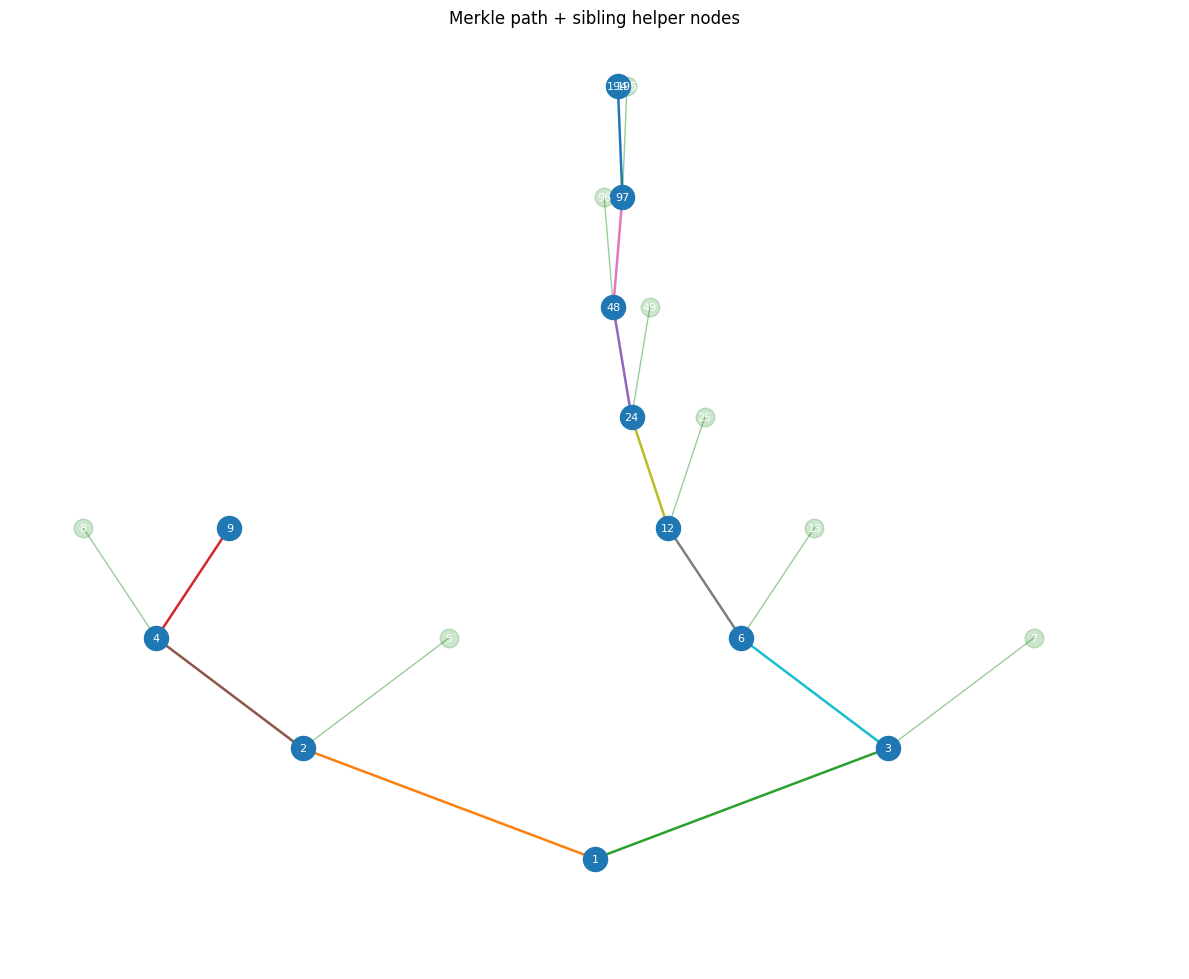

In [23]:
# Case 4: verify proposer index and graffiti agains the beacon block root. Using Merkle Multiproof
# `POST` https://RPC/eth/v1/beacon/states/finalized/query
# {
#   "query": [
#     {
#       "path": ".proposer_index",
#       "include_proof": true
#     },
#     {
#       "path": ".body.graffiti",
#       "include_proof": true
#     }
#   ], 
#   "proof_type": "merkle_multiproof"
# }


from eth2spec.electra.mainnet import BeaconBlock, Bytes32
from remerkleable.core import Path

# ‣ 1. Generalized indices for the two fields
pi_gindex       = (Path(BeaconBlock) / 'proposer_index').gindex()
graffiti_gindex = (Path(BeaconBlock) / 'body' / 'graffiti').gindex()

# ‣ 2. Witnesses (single-branch proofs) for each leaf
pi_branch  = compute_merkle_proof(block, pi_gindex)
gr_branch  = compute_merkle_proof(block, graffiti_gindex)

# ‣ 3. Leaves (already SSZ-padded to 32 bytes)
leaf_pi       = Bytes32(block.proposer_index.to_bytes(8, 'little') + b'\x00' * 24)
leaf_graffiti = block.body.graffiti                     # already Bytes32

leaves   = [leaf_pi, leaf_graffiti]
indices  = [GeneralizedIndex(pi_gindex), GeneralizedIndex(graffiti_gindex)]

# ‣ 4. Helper indices + objects map
helper_indices = get_helper_indices(indices)

objects: dict[GeneralizedIndex, Bytes32] = {
    indices[0]: leaf_pi,
    indices[1]: leaf_graffiti,
    **dict(zip(get_branch_indices(indices[0]), pi_branch)),
    **dict(zip(get_branch_indices(indices[1]), gr_branch)),
}

# Proof list must follow helper_indices order
proof = [objects[i] for i in helper_indices]

# ‣ 5. Verify multiproof against block_root
block_root = block.hash_tree_root()
reconstructed = calculate_multi_merkle_root(leaves, proof, indices)

assert reconstructed == block_root
print("Multiproof OK – reconstructed root:", reconstructed.hex())

plot_merkle_paths([pi_gindex, graffiti_gindex])